## Initial Pre-training of Weights

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 32

In [13]:
path = Path('/storage/brain_tumor_dataset/')
path.ls()

[PosixPath('/storage/brain_tumor_dataset/models'),
 PosixPath('/storage/brain_tumor_dataset/yes'),
 PosixPath('/storage/brain_tumor_dataset/no')]

In [14]:
fnames = get_image_files(path)

In [15]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=128,
                                  bs = bs, valid_pct=0.2).normalize(imagenet_stats)

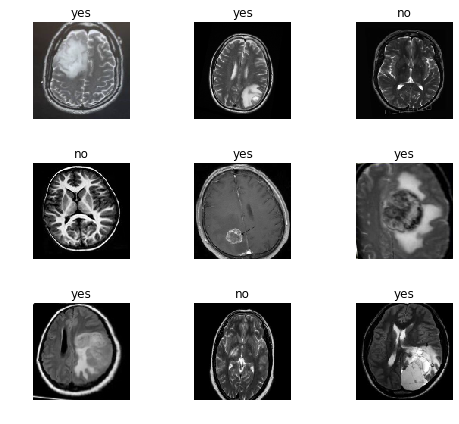

In [7]:
data.show_batch(rows=3, figsize=(7,6))

In [30]:
data

ImageDataBunch;

Train: LabelList (203 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
yes,yes,yes,yes,yes
Path: /storage/brain_tumor_dataset;

Valid: LabelList (50 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
no,yes,yes,yes,yes
Path: /storage/brain_tumor_dataset;

Test: None

In [31]:
print(data.classes)
len(data.classes),data.c

['no', 'yes']


(2, 2)

### Training: resnet34

In [8]:
learn = cnn_learner(data, 
                    models.resnet34, 
                    metrics=[error_rate, dice, accuracy], 
                    callback_fns = ShowGraph)

epoch,train_loss,valid_loss,error_rate,dice,accuracy,time
0,0.868468,0.449673,0.200000,0.800000,0.800000,00:02
1,0.729821,0.226655,0.060000,0.940000,0.940000,00:01
2,0.615770,0.257081,0.120000,0.880000,0.880000,00:01
3,0.556703,0.376479,0.140000,0.860000,0.860000,00:02
4,0.486754,0.425806,0.160000,0.840000,0.840000,00:02
5,0.448683,0.393732,0.200000,0.800000,0.800000,00:02
6,0.404314,0.343638,0.080000,0.920000,0.920000,00:01
7,0.377295,0.318722,0.060000,0.940000,0.940000,00:01
8,0.349021,0.336656,0.120000,0.880000,0.880000,00:01
9,0.323538,0.338501,0.100000,0.900000,0.900000,00:01


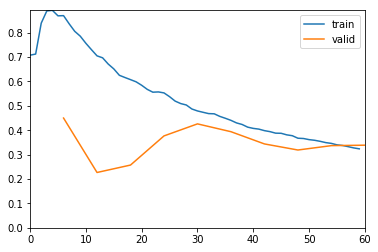

In [9]:
learn.fit_one_cycle(10)

In [10]:
learn.save('stage-1')

### Results

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

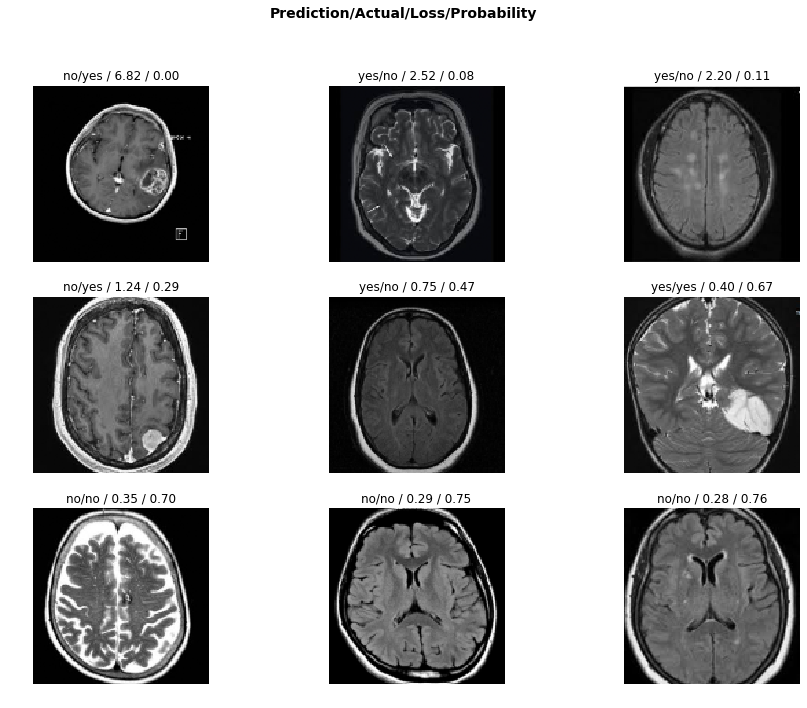

In [12]:
interp.plot_top_losses(9, figsize=(15,11))

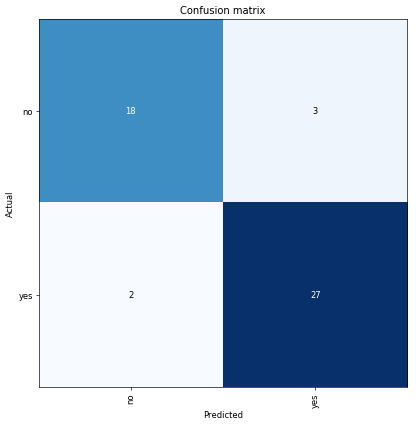

In [13]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

### Unfreeze

In [14]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


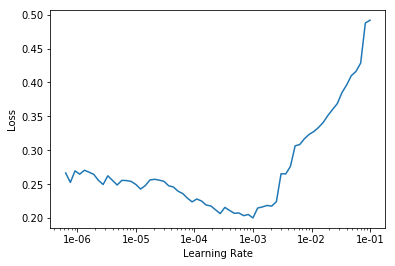

In [16]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,dice,accuracy,time
0,0.276007,0.349808,0.100000,0.900000,0.900000,00:02
1,0.242446,0.327560,0.100000,0.900000,0.900000,00:02
2,0.239100,0.309196,0.100000,0.900000,0.900000,00:02
3,0.218984,0.341516,0.120000,0.880000,0.880000,00:02
4,0.204188,0.318101,0.120000,0.880000,0.880000,00:02
5,0.196742,0.345042,0.080000,0.920000,0.920000,00:02
6,0.186621,0.354436,0.080000,0.920000,0.920000,00:02
7,0.168476,0.350136,0.080000,0.920000,0.920000,00:02
8,0.154351,0.350286,0.080000,0.920000,0.920000,00:02
9,0.139451,0.348736,0.080000,0.920000,0.920000,00:02


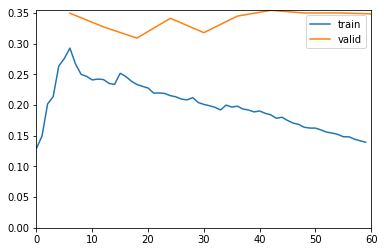

In [17]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-3))

In [18]:
learn.save('stage-2')

## Training: resnet50

In [19]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), valid_pct=0.2,
                                   size=128, bs=bs//2).normalize(imagenet_stats)

In [20]:
learn = cnn_learner(data,
                    models.resnet50, 
                    metrics=[error_rate, dice, accuracy],
                    callback_fns = ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


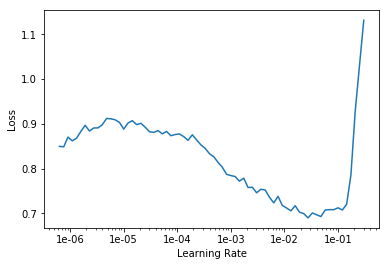

In [21]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,dice,accuracy,time
0,0.736491,0.432570,0.200000,0.800000,0.800000,00:02
1,0.588868,0.478901,0.160000,0.840000,0.840000,00:02
2,0.564177,0.370410,0.120000,0.880000,0.880000,00:02
3,0.482531,0.544292,0.180000,0.820000,0.820000,00:02
4,0.418208,0.377898,0.240000,0.760000,0.760000,00:02
5,0.384213,0.345419,0.140000,0.860000,0.860000,00:02
6,0.336476,0.349893,0.140000,0.860000,0.860000,00:02
7,0.313692,0.318228,0.120000,0.880000,0.880000,00:02
8,0.277628,0.273916,0.120000,0.880000,0.880000,00:02
9,0.270234,0.287048,0.120000,0.880000,0.880000,00:02


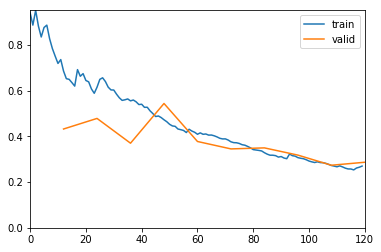

In [22]:
learn.fit_one_cycle(10)

In [23]:
learn.save('stage-1-50')

epoch,train_loss,valid_loss,error_rate,dice,accuracy,time
0,0.148648,0.310954,0.120000,0.880000,0.880000,00:02
1,0.178422,0.278150,0.120000,0.880000,0.880000,00:02
2,0.175743,0.289993,0.120000,0.880000,0.880000,00:02
3,0.171712,0.285393,0.120000,0.880000,0.880000,00:02
4,0.163297,0.295084,0.140000,0.860000,0.860000,00:02
5,0.173351,0.293560,0.140000,0.860000,0.860000,00:02
6,0.158240,0.262455,0.100000,0.900000,0.900000,00:02
7,0.166727,0.266872,0.140000,0.860000,0.860000,00:02
8,0.163684,0.270204,0.120000,0.880000,0.880000,00:02
9,0.182088,0.282903,0.140000,0.860000,0.860000,00:02


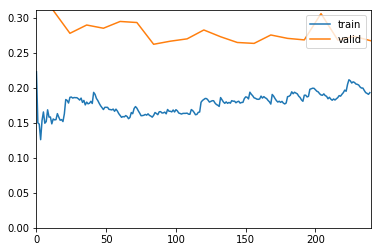

In [24]:
learn.fit_one_cycle(20, max_lr=slice(1e-6,1e-4))

In [25]:
learn.save('stage-2-50')

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

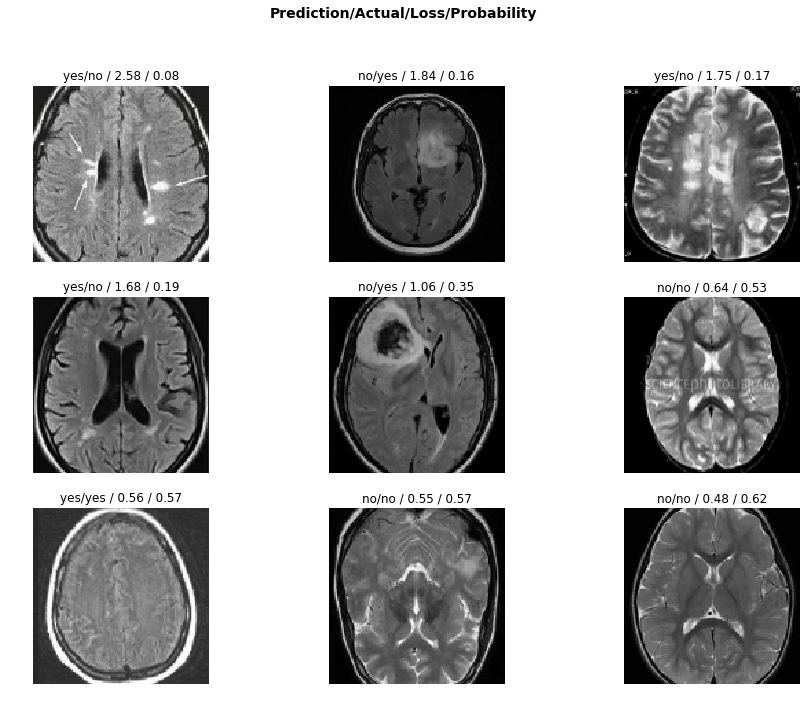

In [27]:
interp.plot_top_losses(9, figsize=(15,11))

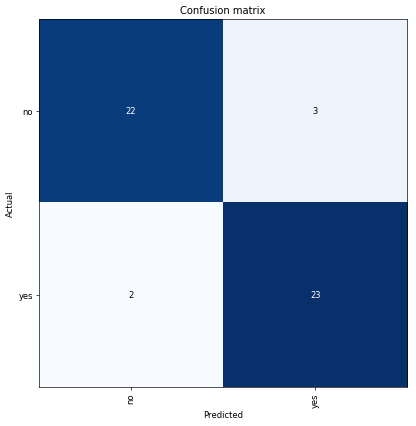

In [28]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

## Transfer Learning to FLAIR Segmentation

### Size = 64

In [78]:
path = Path('/storage/brats2013/brain_segmentation')

In [79]:
train = path/'train'
valid = path/'valid'

In [80]:
from torch.utils.data import Dataset, DataLoader

In [81]:
re = r'(\w+.png)*$'

In [82]:
def create_databunch(path, size, batch_size, regex = None):
    dataset = ImageList.from_folder(path).split_by_folder()
    ds_tfms = dataset.label_from_re(regex).transform(get_transforms(), size=size)
    return ds_tfms.databunch(bs = batch_size)

In [83]:
data = create_databunch(path, size = 64, batch_size = 32, regex = re)

In [84]:
data

ImageDataBunch;

Train: LabelList (2125 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
False.png,False.png,True.png,True.png,False.png
Path: /storage/brats2013/brain_segmentation;

Valid: LabelList (1415 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
True.png,True.png,True.png,True.png,True.png
Path: /storage/brats2013/brain_segmentation;

Test: None

In [85]:
learn = cnn_learner(data,
                    models.resnet34, 
                    metrics=[error_rate, dice, accuracy],
                    callback_fns = ShowGraph)

In [86]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

epoch,train_loss,valid_loss,error_rate,dice,accuracy,time
0,0.746381,0.470672,0.238869,0.761131,0.761131,00:05
1,0.669891,0.383705,0.188693,0.811307,0.811307,00:04
2,0.614552,0.358994,0.178799,0.821201,0.821201,00:04
3,0.578591,0.368344,0.178092,0.821908,0.821908,00:04
4,0.562742,0.356675,0.194346,0.805654,0.805654,00:04
5,0.530084,0.329293,0.156890,0.843110,0.843110,00:04
6,0.516867,0.323258,0.148410,0.851590,0.851590,00:04
7,0.506464,0.324247,0.154770,0.845230,0.845230,00:04
8,0.491316,0.325018,0.161837,0.838163,0.838163,00:04
9,0.487465,0.327142,0.155477,0.844523,0.844523,00:04


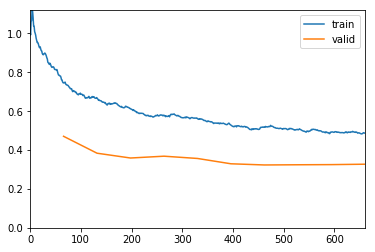

In [87]:
learn.fit_one_cycle(10)

In [88]:
learn.save('stage-1-34-s64')

In [89]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

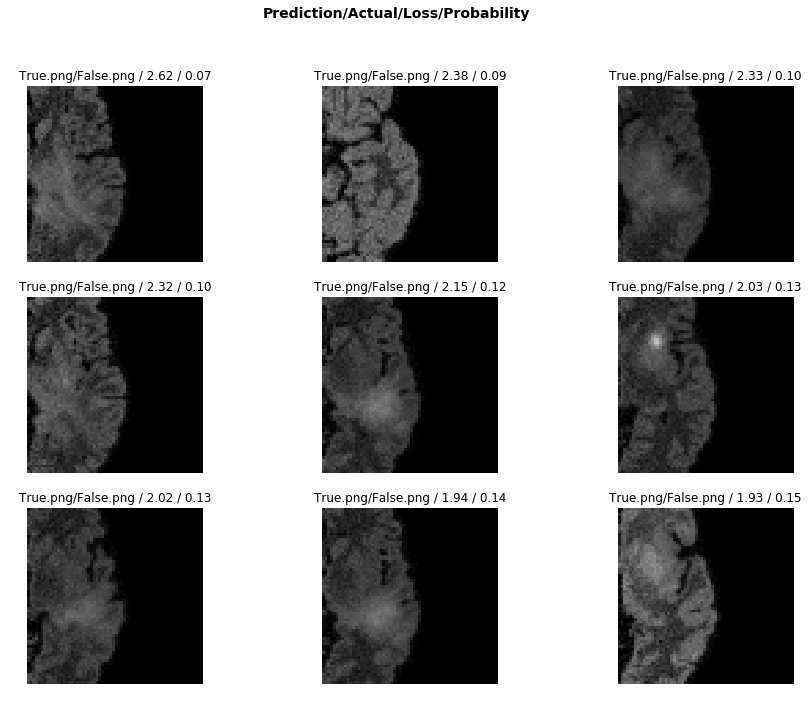

In [90]:
interp.plot_top_losses(9, figsize=(15,11))

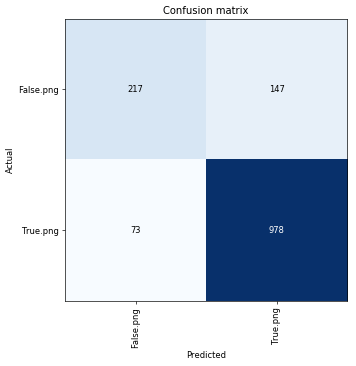

In [92]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

## Unfreeze Body + Fine-tune

In [93]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


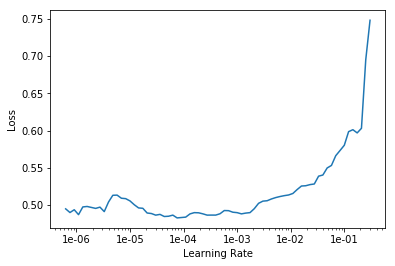

In [94]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,dice,accuracy,time
0,0.491940,0.327348,0.168905,0.831095,0.831095,00:05
1,0.493886,0.349035,0.171025,0.828975,0.828975,00:05
2,0.500868,0.311933,0.154064,0.845936,0.845936,00:05
3,0.490213,0.295532,0.137102,0.862898,0.862898,00:04
4,0.469945,0.302087,0.122968,0.877032,0.877032,00:04
5,0.454096,0.301576,0.127915,0.872085,0.872085,00:05
6,0.453631,0.328791,0.186572,0.813428,0.813428,00:04
7,0.436897,0.285126,0.115901,0.884099,0.884099,00:05
8,0.419917,0.291096,0.125795,0.874205,0.874205,00:05
9,0.414207,0.296594,0.127915,0.872085,0.872085,00:05


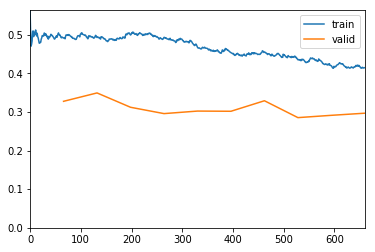

In [95]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,3e-3))

In [96]:
learn.save('stage-2-34-s64')

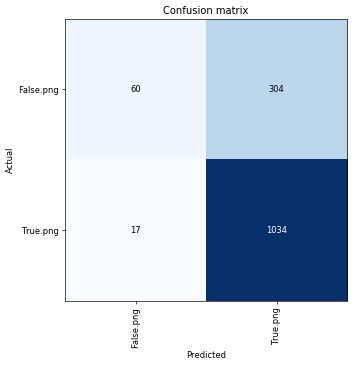

In [109]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

### Size = 128

In [108]:
learn.load('stage-2-34-s64')

Learner(data=ImageDataBunch;

Train: LabelList (2125 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
False.png,False.png,True.png,True.png,False.png
Path: /storage/brats2013/brain_segmentation;

Valid: LabelList (1415 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
True.png,True.png,True.png,True.png,True.png
Path: /storage/brats2013/brain_segmentation;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [104]:
data = create_databunch(path, size = 128, batch_size = 32, regex = re)

In [105]:
learn.data = data

epoch,train_loss,valid_loss,error_rate,dice,accuracy,time
0,0.479078,0.354341,0.187986,0.812014,0.812014,00:07
1,0.511455,0.357538,0.184452,0.815548,0.815548,00:07
2,0.496358,0.343555,0.180212,0.819788,0.819788,00:07
3,0.496275,0.354526,0.185866,0.814134,0.814134,00:07


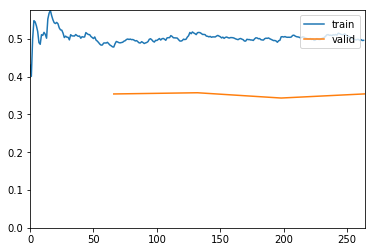

epoch,train_loss,valid_loss,error_rate,dice,accuracy,time
0,0.492478,0.356560,0.183039,0.816961,0.816961,00:07
1,0.493730,0.365609,0.181625,0.818375,0.818375,00:07
2,0.482865,0.353917,0.185159,0.814841,0.814841,00:07
3,0.493941,0.356185,0.183746,0.816254,0.816254,00:07


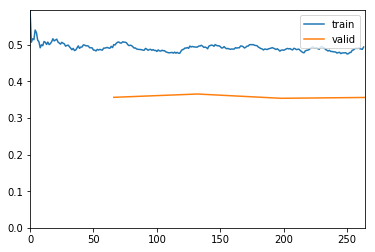

In [107]:
learn.fit_one_cycle(4, max_lr=slice(1e-6))
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


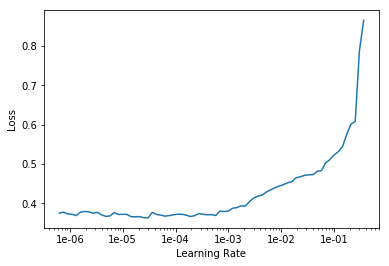

In [101]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

### resnet50

#### Stage 1

In [110]:
data = create_databunch(path, size = 64, batch_size = 32, regex = re)

In [111]:
learn = cnn_learner(data,
                    models.resnet50, 
                    metrics=[error_rate, dice, accuracy],
                    callback_fns = ShowGraph)

epoch,train_loss,valid_loss,error_rate,dice,accuracy,time
0,0.787433,0.576103,0.281272,0.718728,0.718728,00:06
1,0.713510,0.394717,0.195760,0.804240,0.804240,00:05
2,0.613548,0.350959,0.173852,0.826148,0.826148,00:04
3,0.577695,0.367603,0.195053,0.804947,0.804947,00:05
4,0.534810,0.339558,0.166078,0.833922,0.833922,00:05
5,0.521756,0.350733,0.174558,0.825442,0.825442,00:05
6,0.504342,0.331506,0.163251,0.836749,0.836749,00:05
7,0.499827,0.329629,0.160424,0.839576,0.839576,00:05


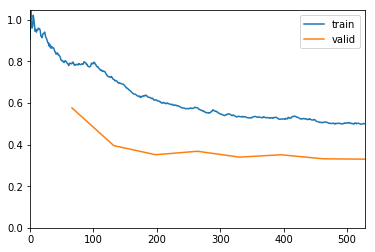

In [112]:
learn.fit_one_cycle(8)

In [113]:
learn.save('stage-1-50-s64')

#### Stage 2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


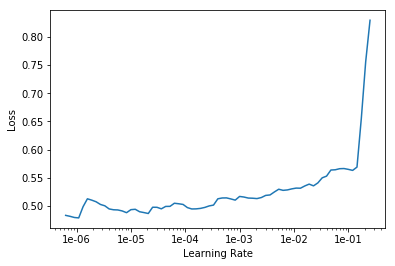

In [114]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,dice,accuracy,time
0,0.498705,0.329167,0.160424,0.839576,0.839576,00:06
1,0.502340,0.320632,0.154064,0.845936,0.845936,00:06
2,0.484633,0.328157,0.159717,0.840283,0.840283,00:06
3,0.488427,0.328629,0.151943,0.848057,0.848057,00:06
4,0.475515,0.320400,0.153357,0.846643,0.846643,00:06
5,0.476068,0.313153,0.145583,0.854417,0.854417,00:06
6,0.482197,0.315213,0.146290,0.853710,0.853710,00:06
7,0.469775,0.313046,0.144876,0.855124,0.855124,00:06
8,0.467396,0.313123,0.148410,0.851590,0.851590,00:06
9,0.457147,0.315440,0.149823,0.850177,0.850177,00:06


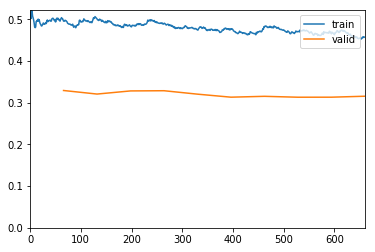

In [115]:
learn.fit_one_cycle(10, max_lr = slice(1e-6, 1e-4))

In [116]:
learn.save('stage-2-50-s64')

#### Stage 3

In [ ]:
learn.load('stage-2-50-s64')

In [117]:
data = create_databunch(path, size = 128, batch_size = 32, regex = re)

In [118]:
learn.data = data

epoch,train_loss,valid_loss,error_rate,dice,accuracy,time
0,0.469577,0.343224,0.186572,0.813428,0.813428,00:11
1,0.477011,0.484763,0.207774,0.792226,0.792226,00:11
2,0.471062,0.388961,0.221908,0.778092,0.778092,00:11
3,0.453549,0.417145,0.197880,0.802120,0.802120,00:11
4,0.427641,0.313026,0.154064,0.845936,0.845936,00:11
5,0.409452,0.400934,0.180919,0.819081,0.819081,00:11
6,0.374674,0.437364,0.216254,0.783746,0.783746,00:11
7,0.369160,0.406842,0.183746,0.816254,0.816254,00:11


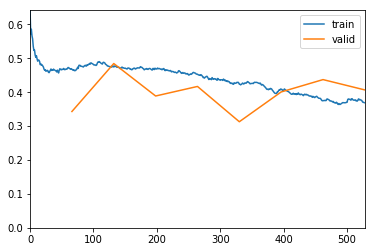

In [119]:
learn.fit_one_cycle(8)

In [120]:
learn.save('stage-1-50-s128')

In [130]:
learn.load('stage-1-50-s128')

Learner(data=ImageDataBunch;

Train: LabelList (2125 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
False.png,False.png,True.png,True.png,False.png
Path: /storage/brats2013/brain_segmentation;

Valid: LabelList (1415 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
True.png,True.png,True.png,True.png,True.png
Path: /storage/brats2013/brain_segmentation;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1)

### Size = 256

In [131]:
data = create_databunch(path, size = 256, batch_size = 32, regex = re)

In [132]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


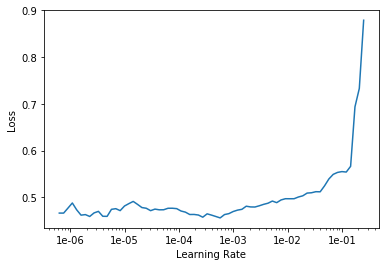

In [133]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,dice,accuracy,time
0,0.439945,0.265064,0.115194,0.884806,0.884806,00:33
1,0.420623,0.263798,0.120141,0.879859,0.879859,00:33
2,0.408245,0.301604,0.154064,0.845936,0.845936,00:33
3,0.391576,0.292687,0.149823,0.850177,0.850177,00:33
4,0.383708,0.263027,0.121555,0.878445,0.878445,00:33
5,0.371636,0.277379,0.139223,0.860777,0.860777,00:33
6,0.359704,0.289491,0.139929,0.860071,0.860071,00:33
7,0.356660,0.303879,0.145583,0.854417,0.854417,00:33
8,0.345746,0.307956,0.154064,0.845936,0.845936,00:33
9,0.333074,0.323023,0.162544,0.837456,0.837456,00:33


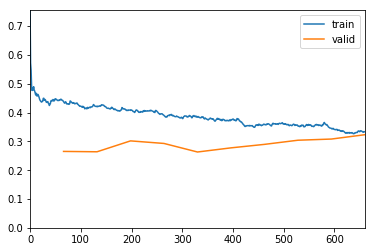

In [134]:
learn.fit_one_cycle(10, max_lr = slice(1e-6, 1e-3))

In [135]:
learn.save('stage-1-50-s256')

In [ ]:
learn.load('stage-1-50-s256')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


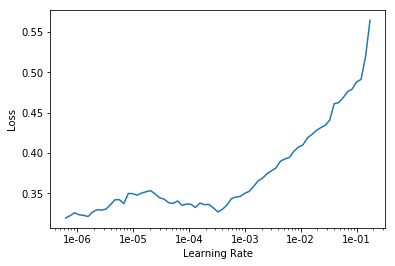

In [136]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,dice,accuracy,time
0,0.348634,0.315474,0.151943,0.848057,0.848057,00:33
1,0.354429,0.321652,0.161131,0.838869,0.838869,00:33
2,0.344469,0.310358,0.148410,0.851590,0.851590,00:33
3,0.339410,0.312392,0.150530,0.849470,0.849470,00:33
4,0.332704,0.312228,0.155477,0.844523,0.844523,00:33
5,0.329673,0.315266,0.154770,0.845230,0.845230,00:33
6,0.321497,0.304306,0.148410,0.851590,0.851590,00:33
7,0.327071,0.302299,0.146290,0.853710,0.853710,00:34
8,0.340127,0.317165,0.151943,0.848057,0.848057,00:34
9,0.324693,0.309723,0.151943,0.848057,0.848057,00:33


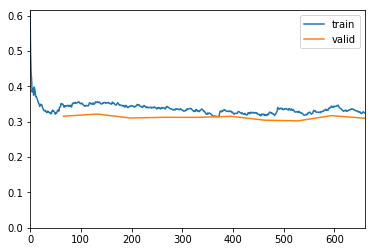

In [137]:
learn.fit_one_cycle(10, max_lr = slice(1e-6, 1e-5))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


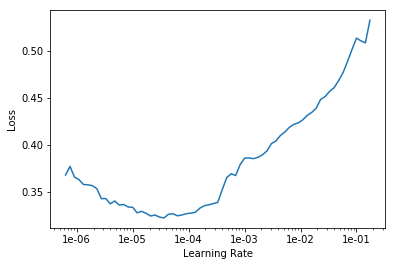

In [138]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,dice,accuracy,time
0,0.316004,0.312682,0.151237,0.848763,0.848763,00:33
1,0.330738,0.370899,0.161837,0.838163,0.838163,00:34
2,0.348754,0.343057,0.151943,0.848057,0.848057,00:34
3,0.346612,0.282147,0.133569,0.866431,0.866431,00:33
4,0.325921,0.359602,0.156890,0.843110,0.843110,00:33
5,0.301791,0.345013,0.149823,0.850177,0.850177,00:33
6,0.289532,0.340616,0.151943,0.848057,0.848057,00:33
7,0.284763,0.337370,0.150530,0.849470,0.849470,00:33
8,0.273107,0.365236,0.159011,0.840989,0.840989,00:33
9,0.264361,0.373213,0.166078,0.833922,0.833922,00:33


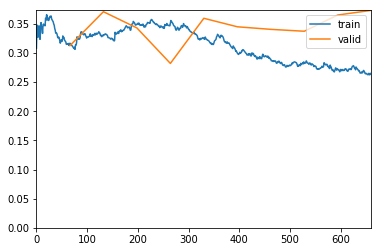

In [139]:
learn.fit_one_cycle(10, max_lr = slice(1e-5, 1e-4))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


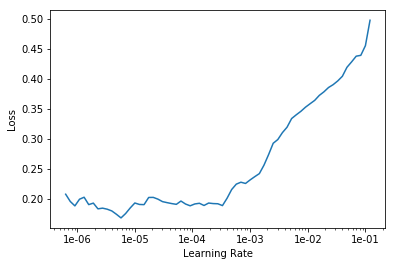

In [146]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [158]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,dice,accuracy,time
0,0.325512,0.294475,0.130742,0.869258,0.869258,00:33


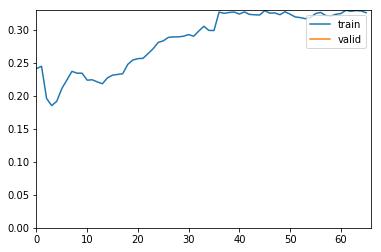

In [159]:
learn.fit_one_cycle(1)

In [160]:
learn.save('stage-3-50-s256')

## Export Model

In [161]:
learn.export('export.pkl')